In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

In [2]:
!pip install ultralytics


In [6]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [3]:
# Path to the CSV and image folder
csv_path = r"C:\Users\HP\Downloads\DATA SCIENTIST_ASSIGNMENT-20250507T124548Z-001\DATA SCIENTIST_ASSIGNMENT\cars.csv"
image_folder = r"C:\Users\HP\Downloads\DATA SCIENTIST_ASSIGNMENT-20250507T124548Z-001\DATA SCIENTIST_ASSIGNMENT\car\license_plates_detection_train"  # <<< Replace with your actual image path

# Read CSV
df = pd.read_csv(csv_path)

# Initialize dictionary
labels_dict = dict(img_path=[], xmin=[], xmax=[], ymin=[], ymax=[], img_w=[], img_h=[])

for idx, row in df.iterrows():
    img_name = row['img_id']  # Column name in your CSV
    img_path = os.path.join(image_folder, img_name)

    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image: {img_path}")
        continue

    h, w, _ = img.shape

    # Append to dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(row['xmin'])
    labels_dict['xmax'].append(row['xmax'])
    labels_dict['ymin'].append(row['ymin'])
    labels_dict['ymax'].append(row['ymax'])
    labels_dict['img_w'].append(w)
    labels_dict['img_h'].append(h)

# Create dataframe
alldata = pd.DataFrame(labels_dict)
alldata


,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,C:\Users\HP\Downloads\DATA SCIENTIST_ASSIGNMEN...,94,169,276,326,850,477
1,C:\Users\HP\Downloads\DATA SCIENTIST_ASSIGNMEN...,395,444,311,344,639,479
2,C:\Users\HP\Downloads\DATA SCIENTIST_ASSIGNMEN...,263,434,406,450,729,547
3,C:\Users\HP\Downloads\DATA SCIENTIST_ASSIGNMEN...,363,494,283,315,850,477
4,C:\Users\HP\Downloads\DATA SCIENTIST_ASSIGNMEN...,42,222,139,280,409,547
...,...,...,...,...,...,...,...
895,C:\Users\HP\Downloads\DATA SCIENTIST_ASSIGNMEN...,34,140,426,508,729,547
896,C:\Users\HP\Downloads\DATA SCIENTIST_ASSIGNMEN...,378,548,356,457,729,547
897,C:\Users\HP\Downloads\DATA SCIENTIST_ASSIGNMEN...,149,217,229,283,850,455
898,C:\Users\HP\Downloads\DATA SCIENTIST_ASSIGNMEN...,252,383,272,300,663,547


In [4]:
train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
      {len(train) = }
      {len(val) = }
      {len(test) = }
''')


      len(train) = 720
      len(val) = 90
      len(test) = 90



In [5]:
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

def make_split_folder_in_yolo_format(split_name, split_df):
    labels_path = os.path.join('datasets', 'cars_license_plate', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate', split_name, 'images')

    os.makedirs(labels_path)
    os.makedirs(images_path)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"created '{images_path}' and '{labels_path}'")

make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

created 'datasets\cars_license_plate\train\images' and 'datasets\cars_license_plate\train\labels'
created 'datasets\cars_license_plate\val\images' and 'datasets\cars_license_plate\val\labels'
created 'datasets\cars_license_plate\test\images' and 'datasets\cars_license_plate\test\labels'


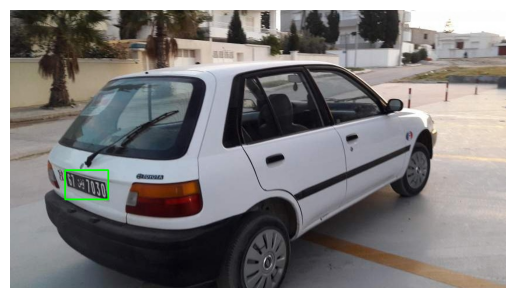

In [6]:
'''
Plot the first train image and its bounding box.
'''
image_dir = 'datasets/cars_license_plate/train/images'
label_dir = 'datasets/cars_license_plate/train/labels'
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
with open(label_path, 'r') as f:
    lines = f.readlines()
for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(image)
plt.axis('off')
plt.show()

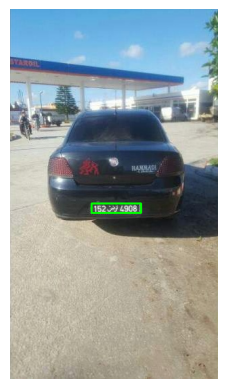

In [7]:
'''
Plot the first train image and its bounding box.
'''
image_dir = 'datasets/cars_license_plate/train/images'
label_dir = 'datasets/cars_license_plate/train/labels'
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[20]
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
with open(label_path, 'r') as f:
    lines = f.readlines()
for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(image)
plt.axis('off')
plt.show()

In [12]:
datasets_yaml = '''
path: cars_license_plate

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 83.7MB/s]


In [13]:
model.train(
    data='datasets.yaml',
    epochs=88,
    batch=16,
    device='cuda',
    imgsz=320,
    cache=True,
)

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets.yaml, epochs=88, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 20.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 89.5MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/cars_license_plate/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 784.90it/s]

train: New cache created: /content/datasets/cars_license_plate/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:05<00:00, 62.10it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/cars_license_plate/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 333.19it/s]

val: New cache created: /content/datasets/cars_license_plate/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 82.97it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 88 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/88      1.26G      1.878      3.541      1.375         19        320: 100%|██████████| 22/22 [00:07<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         44         44      0.648      0.818      0.712      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/88      1.21G      1.521       1.15      1.149         19        320: 100%|██████████| 22/22 [00:02<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]

                   all         44         44      0.568       0.75      0.647      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/88      1.27G      1.504      1.089      1.223         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]

                   all         44         44      0.274      0.523      0.273      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/88      1.23G      1.492      1.098      1.229         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]

                   all         44         44      0.193      0.318     0.0963     0.0474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/88      1.24G      1.492      1.072      1.226         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]

                   all         44         44      0.218      0.409      0.217      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/88      1.25G      1.512      1.008      1.229         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


                   all         44         44      0.324      0.386      0.267      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/88      1.23G      1.507     0.9394      1.218         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]

                   all         44         44      0.346      0.727      0.359      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/88      1.21G      1.524     0.9882      1.211         19        320: 100%|██████████| 22/22 [00:03<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]

                   all         44         44      0.206      0.205      0.121     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/88      1.26G      1.398     0.9469      1.184         17        320: 100%|██████████| 22/22 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]

                   all         44         44     0.0566      0.318     0.0292     0.0112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/88      1.22G      1.367     0.8883      1.142         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]

                   all         44         44      0.711      0.614      0.699      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/88      1.26G      1.307     0.8721      1.144         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


                   all         44         44      0.464      0.296      0.291      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/88      1.22G      1.401     0.9037      1.202         21        320: 100%|██████████| 22/22 [00:03<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

                   all         44         44      0.856      0.811      0.837      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/88      1.26G      1.415     0.8958      1.201         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         44         44      0.794      0.841      0.855      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/88      1.21G      1.346     0.8542      1.176         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


                   all         44         44      0.913      0.713      0.867      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/88      1.23G      1.333     0.8148      1.143         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]

                   all         44         44      0.733      0.909      0.878      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/88      1.25G      1.318     0.8019      1.127         13        320: 100%|██████████| 22/22 [00:03<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

                   all         44         44       0.85      0.864      0.904      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/88      1.23G      1.291     0.8089      1.148         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         44         44      0.871      0.841      0.896      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/88      1.21G      1.238      0.752      1.122         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]

                   all         44         44      0.873      0.785       0.85      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/88      1.23G      1.211     0.7191      1.101         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]

                   all         44         44      0.967      0.795       0.91      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/88      1.25G      1.217     0.7266      1.098         24        320: 100%|██████████| 22/22 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.92it/s]

                   all         44         44      0.844      0.886      0.878      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/88      1.23G      1.228     0.7552      1.104         21        320: 100%|██████████| 22/22 [00:04<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         44         44      0.797      0.864      0.853       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/88      1.26G      1.246      0.744      1.143         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]

                   all         44         44      0.858      0.824      0.838      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/88      1.23G      1.237     0.7481      1.125         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]

                   all         44         44      0.926      0.857       0.87      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/88      1.26G      1.173     0.7023      1.112         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.24it/s]

                   all         44         44      0.845      0.867      0.879      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/88      1.26G        1.2     0.7153      1.089         22        320: 100%|██████████| 22/22 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         44         44      0.918      0.909      0.915      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/88      1.25G      1.155     0.6981      1.089         13        320: 100%|██████████| 22/22 [00:02<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]

                   all         44         44      0.858      0.909      0.932      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/88      1.26G      1.098     0.6613      1.065         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

                   all         44         44      0.834        0.8      0.872      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/88      1.22G      1.083     0.6194      1.055         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]

                   all         44         44      0.928       0.88      0.938      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/88      1.23G        1.1     0.6548      1.093         23        320: 100%|██████████| 22/22 [00:04<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         44         44      0.949      0.852      0.939      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/88      1.25G        1.1     0.6407      1.082         17        320: 100%|██████████| 22/22 [00:03<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]

                   all         44         44      0.898      0.909      0.956      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/88      1.26G      1.099     0.6572      1.071         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]

                   all         44         44      0.872      0.909      0.935      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/88      1.26G      1.077     0.6295      1.067         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

                   all         44         44      0.911      0.886      0.952       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/88      1.23G       1.11     0.6327      1.068         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         44         44      0.871      0.924      0.926      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/88      1.26G      1.008     0.6033      1.057         18        320: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]

                   all         44         44      0.924      0.823      0.935      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/88      1.23G      1.014     0.6185      1.034         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]

                   all         44         44      0.869      0.955      0.959      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/88      1.26G      1.075     0.6269      1.044         19        320: 100%|██████████| 22/22 [00:02<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]


                   all         44         44      0.886      0.884      0.886      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/88      1.23G      1.031     0.6024      1.047         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         44         44      0.926      0.886      0.923      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/88      1.22G      1.039     0.5816      1.036         19        320: 100%|██████████| 22/22 [00:03<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]

                   all         44         44      0.795      0.884      0.872      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/88      1.23G      1.003     0.5954      1.038         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]

                   all         44         44       0.91      0.841      0.873      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/88      1.25G     0.9631     0.5493      1.014         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]

                   all         44         44      0.908      0.886      0.891      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/88      1.23G     0.9476     0.5716      1.004         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         44         44      0.882      0.864      0.883      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/88      1.26G     0.9087     0.5402      1.007         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         44         44      0.884      0.863        0.9      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/88      1.23G     0.9561     0.5602      1.022         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]

                   all         44         44      0.905      0.864      0.922      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/88      1.25G     0.9836     0.5462      1.006         13        320: 100%|██████████| 22/22 [00:02<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


                   all         44         44       0.85      0.904      0.932      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/88      1.23G     0.9463     0.5515     0.9843         16        320: 100%|██████████| 22/22 [00:03<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.36it/s]

                   all         44         44      0.923      0.886      0.913       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/88      1.25G     0.9463     0.5487      1.014         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]

                   all         44         44      0.952      0.886      0.932      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/88      1.23G     0.9407     0.5475     0.9884         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]

                   all         44         44      0.886      0.886      0.874      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/88      1.25G     0.8973     0.5184     0.9736         13        320: 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all         44         44      0.908      0.901      0.916      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/88      1.23G     0.8971     0.4929     0.9755         12        320: 100%|██████████| 22/22 [00:03<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.63it/s]

                   all         44         44      0.885      0.871      0.919      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/88      1.26G     0.9278     0.5395     0.9805         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

                   all         44         44       0.92      0.886      0.918      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/88      1.23G     0.8915     0.5193     0.9941         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]

                   all         44         44      0.926      0.909      0.917        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/88      1.26G     0.8721     0.5106     0.9868         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]

                   all         44         44      0.951      0.883      0.925      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/88      1.23G     0.8829     0.5009     0.9735         14        320: 100%|██████████| 22/22 [00:02<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.64it/s]

                   all         44         44      0.939      0.841      0.931      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/88      1.22G     0.8764     0.5027     0.9935         23        320: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         44         44      0.925      0.795      0.904       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/88      1.23G     0.8793      0.523     0.9853         10        320: 100%|██████████| 22/22 [00:03<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

                   all         44         44      0.824      0.886      0.892      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/88      1.25G     0.8335     0.4924      0.958         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]

                   all         44         44      0.924       0.83      0.883      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/88      1.23G     0.8566     0.4949     0.9772         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]

                   all         44         44      0.855      0.864      0.897      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/88      1.26G     0.8386     0.4937     0.9643         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         44         44      0.905      0.862      0.928      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/88      1.23G     0.8387     0.4633     0.9755         15        320: 100%|██████████| 22/22 [00:03<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]

                   all         44         44      0.885      0.878      0.923      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/88      1.22G     0.8476     0.4852     0.9883         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]

                   all         44         44      0.882      0.886      0.887      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/88      1.23G     0.8352     0.4784     0.9796         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]

                   all         44         44      0.907      0.884      0.893      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/88      1.22G     0.8074     0.4819     0.9671         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         44         44      0.905      0.866      0.913      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/88      1.23G     0.7812     0.4564     0.9656          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


                   all         44         44      0.931      0.864      0.948      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/88      1.25G     0.8034       0.47     0.9714         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]

                   all         44         44      0.941      0.909      0.938      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/88      1.23G     0.8092     0.4694     0.9601         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]

                   all         44         44      0.952      0.907      0.946      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/88      1.25G     0.7711     0.4411     0.9412         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         44         44      0.937      0.841      0.931      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/88      1.24G     0.7903     0.4691     0.9464         11        320: 100%|██████████| 22/22 [00:03<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]

                   all         44         44      0.878      0.909      0.947      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/88      1.21G     0.7577     0.4406     0.9307         21        320: 100%|██████████| 22/22 [00:02<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]

                   all         44         44      0.886      0.886       0.94      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/88      1.23G     0.7279     0.4277     0.9472         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


                   all         44         44      0.856      0.955      0.946      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/88      1.25G     0.6998     0.4096     0.9288         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         44         44       0.93      0.904      0.936      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/88      1.24G     0.7606     0.4441     0.9438         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


                   all         44         44      0.939      0.909       0.95      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/88      1.21G     0.7512     0.4342     0.9504         15        320: 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         44         44      0.873      0.938      0.944      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/88      1.24G     0.7636     0.4484     0.9315         16        320: 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


                   all         44         44      0.906      0.878      0.929      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/88      1.25G     0.7467     0.4217      0.939         16        320: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]

                   all         44         44      0.864      0.886      0.923      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/88      1.23G     0.7468     0.4184     0.9512         11        320: 100%|██████████| 22/22 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]

                   all         44         44      0.888      0.904      0.928      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/88      1.26G     0.6915     0.4224     0.9339         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         44         44      0.866      0.932      0.947      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/88      1.23G     0.6949     0.4033     0.9212         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         44         44      0.915      0.886      0.949      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/88      1.25G     0.7086     0.4064     0.9378         14        320: 100%|██████████| 22/22 [00:03<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]

                   all         44         44       0.89      0.918      0.946      0.547


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/88      1.23G     0.9497     0.4979       1.05          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

                   all         44         44      0.889      0.907      0.934       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/88      1.26G     0.9438     0.4668      1.042          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         44         44      0.911      0.932      0.939      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      81/88      1.23G     0.9207     0.4586      1.016          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         44         44      0.949      0.838      0.917      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      82/88      1.25G     0.9273      0.472      1.035          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]

                   all         44         44      0.872      0.925      0.933       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      83/88      1.23G     0.9151     0.4548      1.033          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]

                   all         44         44      0.927      0.861      0.925       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      84/88      1.21G     0.9103     0.4536      1.021          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.83it/s]

                   all         44         44      0.891      0.886      0.937      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      85/88      1.23G     0.8892     0.4326      1.002          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         44         44      0.888      0.901      0.934      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      86/88      1.25G     0.9129     0.4494      1.033          9        320: 100%|██████████| 22/22 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]

                   all         44         44      0.927       0.86      0.934      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      87/88      1.23G     0.9102     0.4422      1.007          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]

                   all         44         44      0.886      0.886      0.934      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      88/88      1.22G     0.8609     0.4308      1.008          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


                   all         44         44      0.882      0.886      0.935      0.552

88 epochs completed in 0.114 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


                   all         44         44      0.866      0.932      0.947      0.554
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e54b3155810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

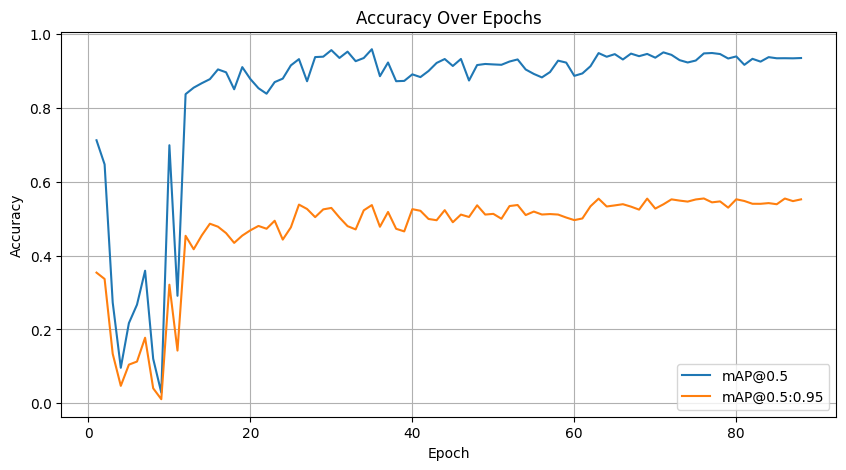

In [14]:
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

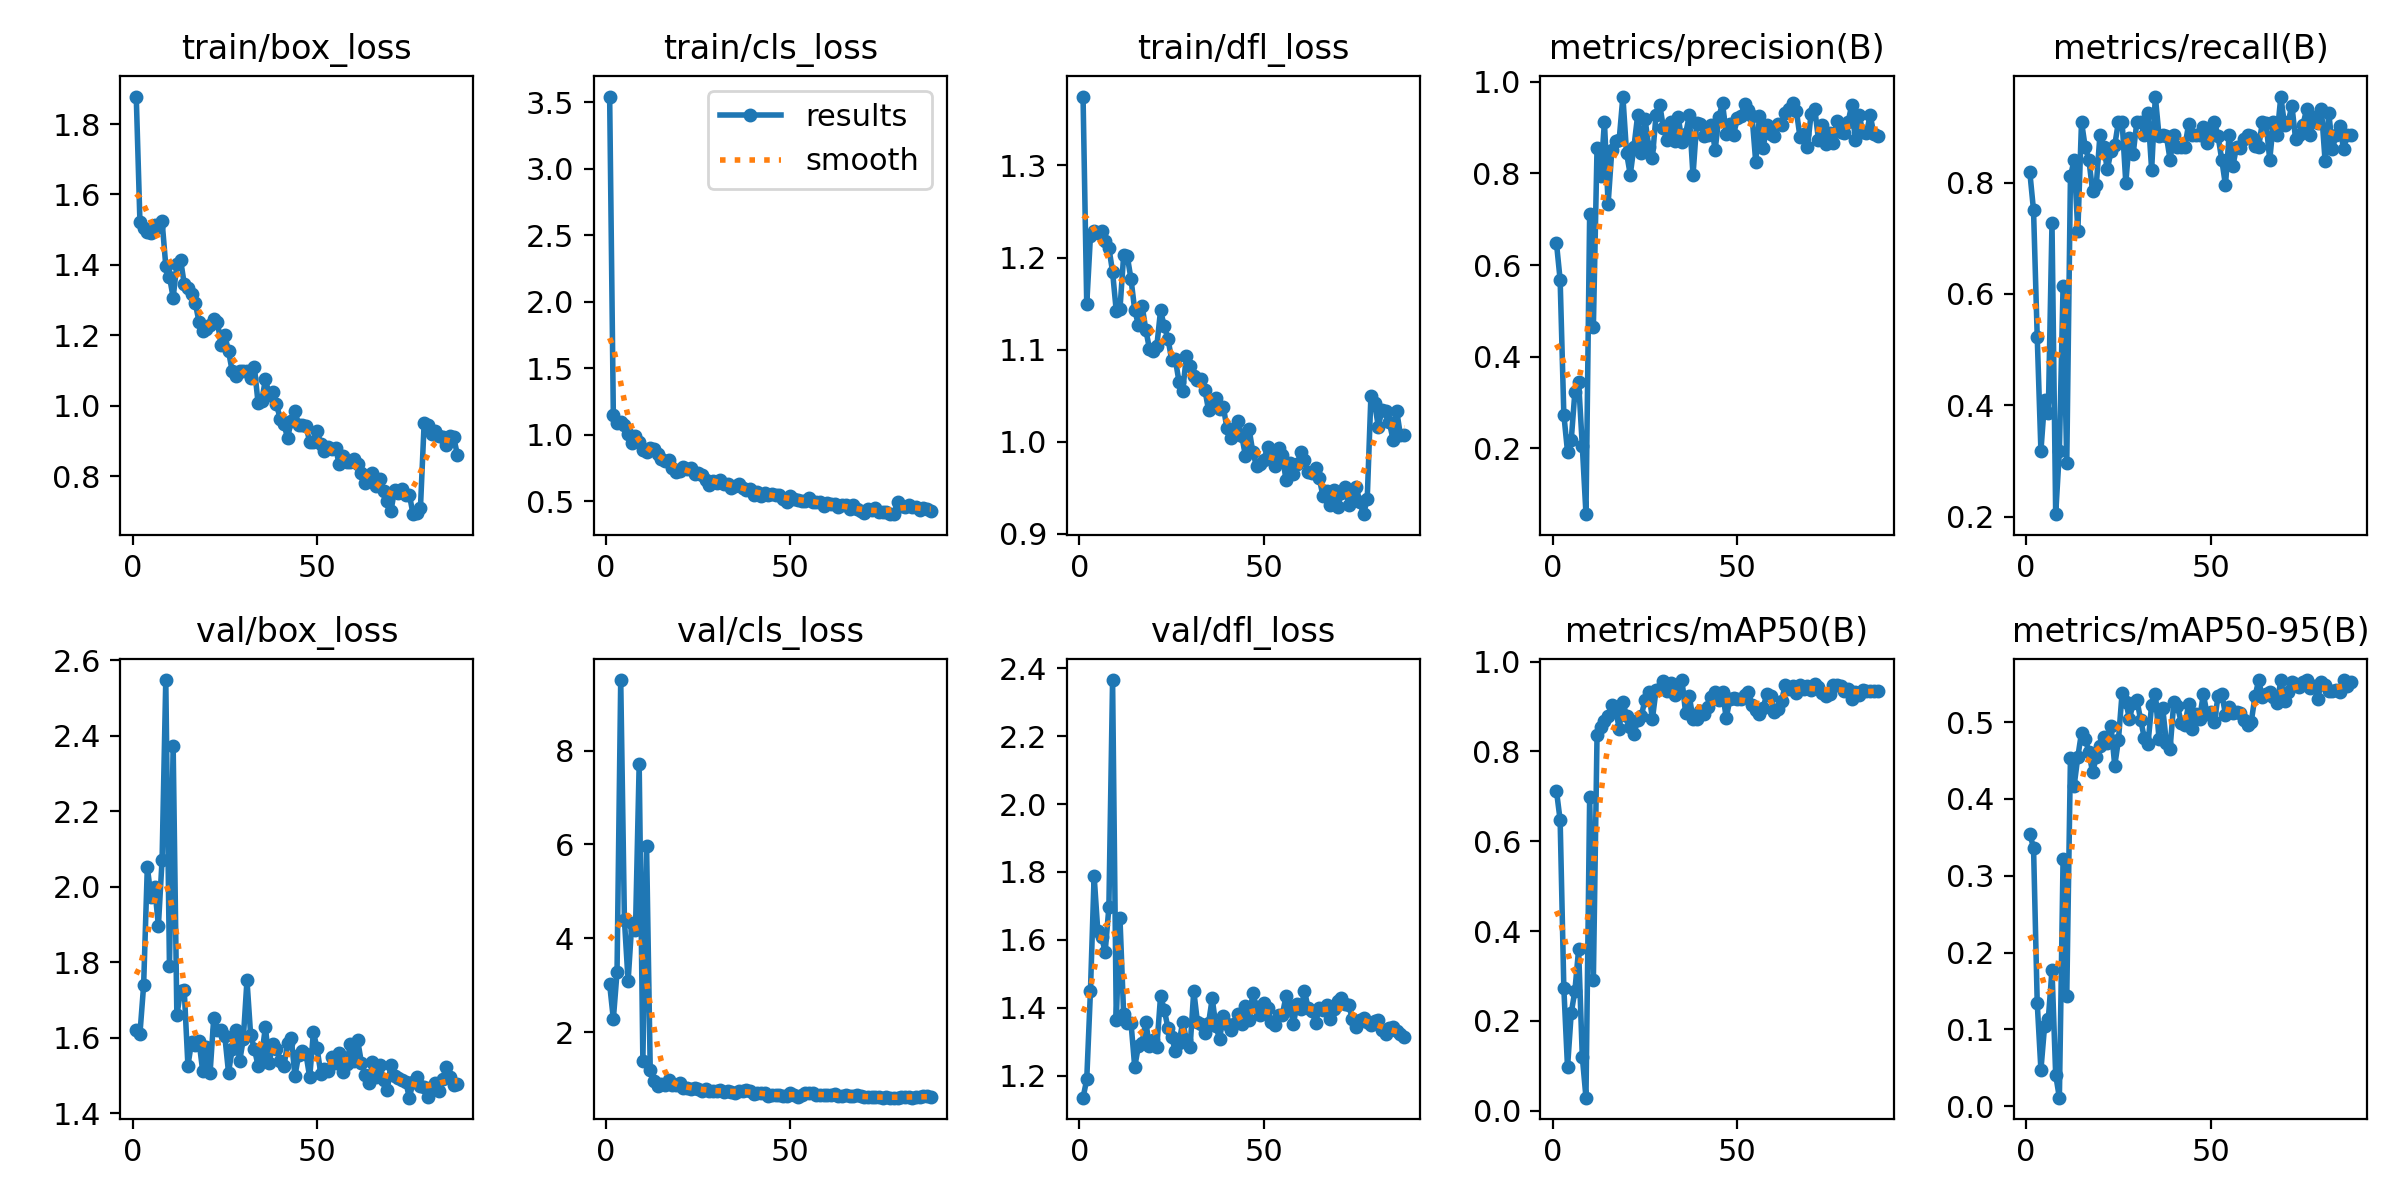

In [15]:
from IPython.display import Image,display

display(Image(filename='/content/runs/detect/train/results.png',width=920))

In [16]:
metrics=model.val(split='val')

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/datasets/cars_license_plate/val/labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 85.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


                   all         44         44      0.866      0.932      0.947      0.555
Speed: 0.2ms preprocess, 9.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train2


In [17]:

print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")
print(f"Mean Average Precision @ .50   : {metrics.box.map50}")
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.5547091837762814
Mean Average Precision @ .50   : 0.9474872105867158
Mean Average Precision @ .70   : 0.5586296446158456


Looking in indexes: https://download.pytorch.org/whl/cu118
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

image 1/1 /content/drive/MyDrive/ocr/new/Samples-of-Characters-for-Recognition-Sample-Indian-Vehicle-Sample-Foreign-Vehicle.png: 256x320 2 license_plates, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)


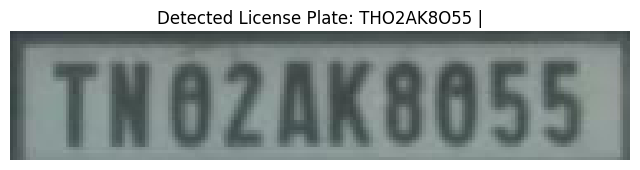

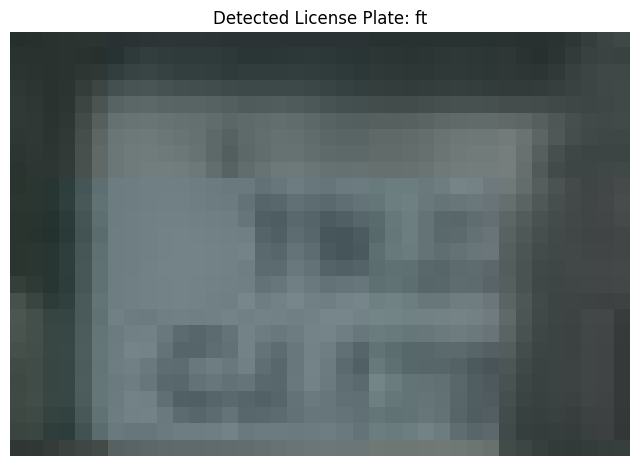


image 1/1 /content/drive/MyDrive/ocr/new/Different-Colour-Number-Pla_62c949963e4e0.webp: 192x320 1 license_plate, 17.5ms
Speed: 1.8ms preprocess, 17.5ms inference, 2.8ms postprocess per image at shape (1, 3, 192, 320)


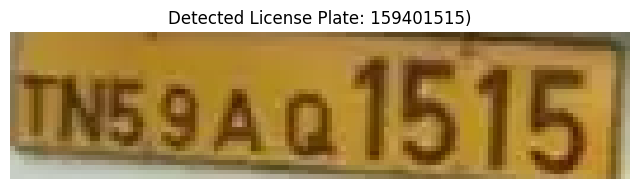


image 1/1 /content/drive/MyDrive/ocr/new/d3.jpg: 256x320 1 license_plate, 17.5ms
Speed: 10.4ms preprocess, 17.5ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)


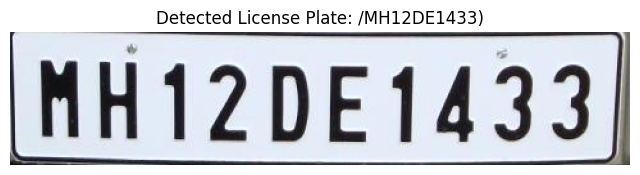


image 1/1 /content/drive/MyDrive/ocr/new/IMG_20170505_165100_HDR.jpg: 256x320 1 license_plate, 7.8ms
Speed: 1.5ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)


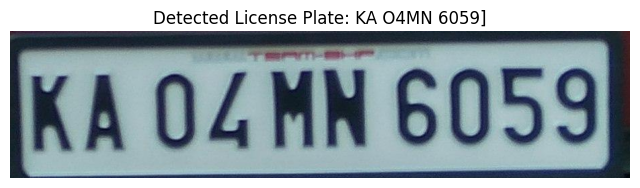


image 1/1 /content/drive/MyDrive/ocr/new/images.jpg: 192x320 1 license_plate, 8.2ms
Speed: 0.8ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 320)


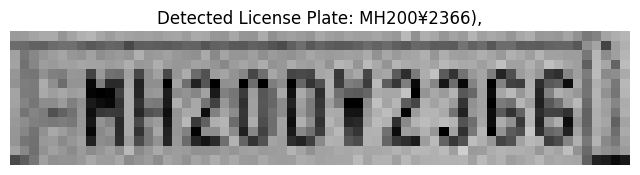


image 1/1 /content/drive/MyDrive/ocr/new/download.jpg: 192x320 1 license_plate, 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 320)


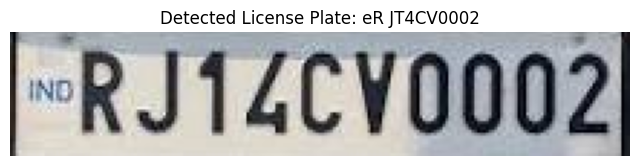


image 1/1 /content/drive/MyDrive/ocr/new/download_n.jpg: 224x320 1 license_plate, 43.9ms
Speed: 0.9ms preprocess, 43.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 320)


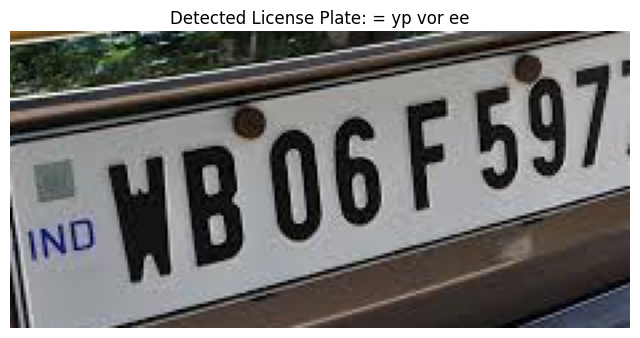


image 1/1 /content/drive/MyDrive/ocr/new/5d49a855-5a55-4b53-96bf-47966bb76ced.jpg: 256x320 1 license_plate, 9.0ms
Speed: 1.1ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)


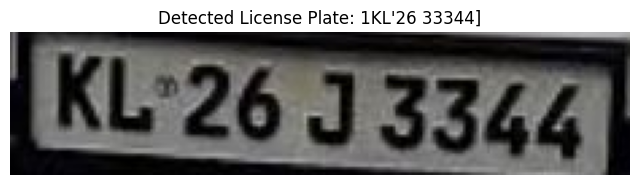

In [26]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install ultralytics
!pip install pytesseract  # Install pytesseract for OCR
!apt install tesseract-ocr  # Install tesseract on the system (for Colab)

import pytesseract
from ultralytics import YOLO
import cv2
import os
import matplotlib.pyplot as plt

# Define the directory containing images
image_dir = "/content/drive/MyDrive/ocr/new"
all_images = os.listdir(image_dir)
selected_images = all_images[:40]  # Select the first 40 images

# Iterate over selected images
for img_name in selected_images:
    img_path = os.path.join(image_dir, img_name)
    results = model.predict(img_path)  # Run prediction

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

    # Loop over each detected object (e.g., license plate)
    for result in results:
        # Extract bounding boxes of detected objects
        for bbox in result.boxes:
            x1, y1, x2, y2 = map(int, bbox.xyxy[0])  # Get coordinates (x1, y1, x2, y2)

            # Crop the license plate region from the image
            plate_img = img[y1:y2, x1:x2]

            # Optionally, convert to grayscale for better OCR results
            gray_plate_img = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

            # Use pytesseract to extract text from the license plate image
            license_plate_text = pytesseract.image_to_string(gray_plate_img, config='--psm 8')  # PSM 8 assumes a single word

            # Display the cropped license plate and extracted text
            plt.figure(figsize=(8, 6))
            plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Detected License Plate: {license_plate_text.strip()}')
            plt.axis('off')
            plt.show()